# Validation Etapes 1 a 4 (vue metier, pedagogique)

Ce notebook montre, de facon simple, que le POC est solide avant une mise en API.

Objectif metier:
1. **Etape 1** - verifier que l'environnement est sain,
2. **Etape 2** - verifier que les donnees OpenAgenda sont bien preparees,
3. **Etape 3** - verifier que la base vectorielle FAISS fonctionne,
4. **Etape 4** - verifier que le moteur RAG repond avec des sources explicites.


## Comment lire ce notebook

- Les cellules **Markdown** expliquent le "pourquoi" en langage metier.
- Les cellules **Code** prouvent que les operations fonctionnent.
- Les graphiques aident a comprendre rapidement la qualite du pipeline.

Conseil: faire `Restart Kernel` puis `Run All`.


In [1]:
from __future__ import annotations

import hashlib
import importlib.metadata as md
import json
import os
import subprocess
import sys
import tempfile
from datetime import date, timedelta
from pathlib import Path

import pandas as pd
import yaml
from IPython.display import Markdown, display

try:
    import matplotlib.pyplot as plt
    MATPLOTLIB_OK = True
except Exception:
    MATPLOTLIB_OK = False


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'config.yaml').exists() and (candidate / 'src').exists():
            return candidate
    raise RuntimeError('Impossible de trouver la racine du projet.')


def draw_bar(labels, values, title, ylabel='Valeur', color='#1f77b4'):
    if not MATPLOTLIB_OK:
        print(f'[visualisation ignoree] {title} (matplotlib non disponible)')
        return
    fig, ax = plt.subplots(figsize=(9, 3.5))
    ax.bar(labels, values, color=color)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', alpha=0.25)
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()


def draw_latency(latency_ms: dict[str, int], title: str):
    if not MATPLOTLIB_OK:
        print(f'[visualisation ignoree] {title} (matplotlib non disponible)')
        return
    labels = list(latency_ms.keys())
    values = [latency_ms[k] for k in labels]
    fig, ax = plt.subplots(figsize=(8.5, 3.2))
    ax.barh(labels, values, color='#2ca02c', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Millisecondes')
    ax.grid(axis='x', alpha=0.25)
    plt.tight_layout()
    plt.show()


PROJECT_ROOT = find_project_root(Path.cwd())
os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('PROJECT_ROOT =', PROJECT_ROOT)
print('Matplotlib disponible =', MATPLOTLIB_OK)


PROJECT_ROOT = /Users/steph/Code/Python/Jupyter/OCR_projet09
Matplotlib disponible = True


## 1) Etape 1 - Sante de l'environnement

Lecture metier:

Avant de parler intelligence artificielle, on verifie que les briques de base sont presentes.
Si cette etape echoue, les resultats seront instables ou impossibles a reproduire.


,component,version,installed
0,python,3.11.3,True
1,langchain,0.0.353,True
2,faiss-cpu,1.13.2,True
3,mistralai,0.4.2,True
4,pandas,2.2.2,True
5,requests,2.32.3,True


,check,status,details
0,import faiss,OK,
1,from langchain.vectorstores import FAISS,OK,
2,from langchain.embeddings import HuggingFaceEm...,OK,
3,from mistral import MistralClient,OK,


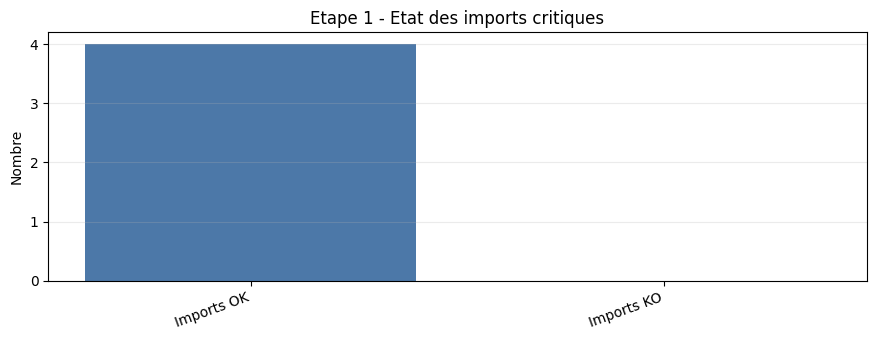

Etape 1 validee: environnement operationnel.


In [2]:
components = [
    ('python', None),
    ('langchain', 'langchain'),
    ('faiss-cpu', 'faiss-cpu'),
    ('mistralai', 'mistralai'),
    ('pandas', 'pandas'),
    ('requests', 'requests'),
]

rows = []
for label, dist_name in components:
    if label == 'python':
        rows.append({'component': label, 'version': f'{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}', 'installed': True})
        continue
    try:
        version = md.version(dist_name)
        rows.append({'component': label, 'version': version, 'installed': True})
    except md.PackageNotFoundError:
        rows.append({'component': label, 'version': 'not installed', 'installed': False})

env_df = pd.DataFrame(rows)
display(env_df)

checks = [
    ('import faiss', 'import faiss'),
    ('from langchain.vectorstores import FAISS', 'from langchain.vectorstores import FAISS'),
    ('from langchain.embeddings import HuggingFaceEmbeddings', 'from langchain.embeddings import HuggingFaceEmbeddings'),
    ('from mistral import MistralClient', 'from mistral import MistralClient'),
]

import_rows = []
for label, stmt in checks:
    try:
        exec(stmt, {})
        import_rows.append({'check': label, 'status': 'OK', 'details': ''})
    except Exception as exc:
        import_rows.append({'check': label, 'status': 'KO', 'details': str(exc)})

imports_df = pd.DataFrame(import_rows)
display(imports_df)

ok_count = int((imports_df['status'] == 'OK').sum())
ko_count = int((imports_df['status'] == 'KO').sum())
draw_bar(['Imports OK', 'Imports KO'], [ok_count, ko_count], 'Etape 1 - Etat des imports critiques', ylabel='Nombre', color='#4c78a8')

assert ko_count == 0, 'Des imports critiques sont en echec.'
print('Etape 1 validee: environnement operationnel.')


## 2) Etape 2 - Perimetre metier et configuration

Lecture metier:

Cette etape garantit que l'assistant travaille dans le bon cadre:
- bon territoire (Herault),
- bonne fenetre temporelle,
- bonne langue (francais).

Cela evite de recommander des evenements hors sujet.


,champ,valeur
0,Departement cible,34
1,Ville pivot,Montpellier
2,Latitude,43.6119
3,Longitude,3.8772
4,Rayon km,55
5,Langue,fr
6,Periode debut,2025-02-10
7,Periode fin,2026-05-11


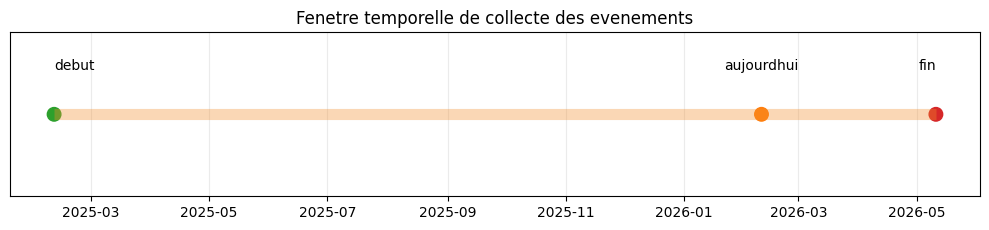

Etape 2 - perimetre metier valide.


In [3]:
config = yaml.safe_load(Path('config.yaml').read_text(encoding='utf-8'))
oa = config['openagenda']

today = date.today()
start_date = oa['time_window'].get('start_date') or str(today - timedelta(days=365))
end_date = oa['time_window'].get('end_date') or str(today + timedelta(days=90))

summary_df = pd.DataFrame([
    {'champ': 'Departement cible', 'valeur': oa['location'].get('department', '')},
    {'champ': 'Ville pivot', 'valeur': oa['location'].get('city', '')},
    {'champ': 'Latitude', 'valeur': oa['location'].get('latitude', '')},
    {'champ': 'Longitude', 'valeur': oa['location'].get('longitude', '')},
    {'champ': 'Rayon km', 'valeur': oa['location'].get('radius_km', '')},
    {'champ': 'Langue', 'valeur': oa['request'].get('language', '')},
    {'champ': 'Periode debut', 'valeur': start_date},
    {'champ': 'Periode fin', 'valeur': end_date},
])
display(summary_df)

start_dt = pd.to_datetime(start_date)
today_dt = pd.to_datetime(str(today))
end_dt = pd.to_datetime(end_date)

if MATPLOTLIB_OK:
    fig, ax = plt.subplots(figsize=(10, 2.4))
    ax.hlines(y=1, xmin=start_dt, xmax=end_dt, linewidth=8, color='#f28e2c', alpha=0.35)
    ax.scatter([start_dt, today_dt, end_dt], [1, 1, 1], s=95, c=['#2ca02c', '#ff7f0e', '#d62728'])
    ax.text(start_dt, 1.03, 'debut', ha='left')
    ax.text(today_dt, 1.03, 'aujourdhui', ha='center')
    ax.text(end_dt, 1.03, 'fin', ha='right')
    ax.set_title('Fenetre temporelle de collecte des evenements')
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.25)
    plt.tight_layout()
    plt.show()

assert oa['location'].get('department') == '34'
assert oa['request'].get('language') == 'fr'
print('Etape 2 - perimetre metier valide.')


## 3) Etape 2 - Recuperation OpenAgenda (mockee, sans reseau)

Lecture metier:

On simule des pages API pour verifier que la pagination est robuste.
L'interet metier: pouvoir relancer les tests sans dependre d'Internet ni d'une API externe.


Evenements recuperes: 2
UIDs: ['evt-1', 'evt-2']


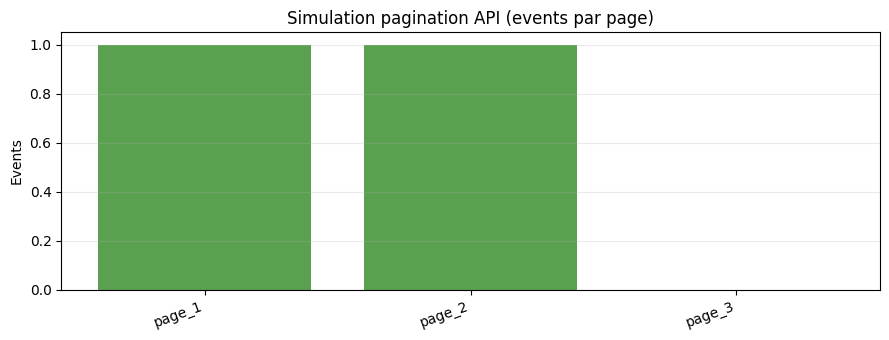

Pagination mockee validee.


In [4]:
from src.openagenda.client import OpenAgendaConfig, fetch_events


class FakeResponse:
    def __init__(self, payload, status_code=200):
        self._payload = payload
        self.status_code = status_code
        self.text = str(payload)

    def json(self):
        return self._payload


class FakeSession:
    def __init__(self, responses):
        self.responses = list(responses)
        self.call_count = 0

    def get(self, url, params=None, timeout=None):
        del url, params, timeout
        self.call_count += 1
        if not self.responses:
            return FakeResponse({'events': []})
        return FakeResponse(self.responses.pop(0))

    def close(self):
        pass


pages = [
    {'events': [{'uid': 'evt-1', 'title': {'fr': 'Evenement 1'}}]},
    {'events': [{'uid': 'evt-2', 'title': {'fr': 'Evenement 2'}}]},
    {'events': []},
]
fake_session = FakeSession(list(pages))

cfg = OpenAgendaConfig(
    base_url='https://api.openagenda.com/v2/events',
    api_key='demo-key',
    department='34',
    city='Montpellier',
    page_size=1,
    max_pages=5,
    max_events=10,
    start_date='2025-01-01',
    end_date='2026-12-31',
)

raw_events = fetch_events(cfg, session=fake_session)
print('Evenements recuperes:', len(raw_events))
print('UIDs:', [evt.get('uid') for evt in raw_events])

page_counts = [len(page.get('events', [])) for page in pages]
draw_bar([f'page_{i+1}' for i in range(len(page_counts))], page_counts, 'Simulation pagination API (events par page)', ylabel='Events', color='#59a14f')

assert len(raw_events) == 2
assert fake_session.call_count == 3
print('Pagination mockee validee.')


## 4) Etape 2 - Nettoyage et structuration des donnees

Lecture metier:

Les donnees brutes sont heterogenes. Cette etape les rend exploitables:
- suppression des doublons,
- filtrage periode,
- controle des champs obligatoires,
- creation d'un texte unifie (`document_text`) pour la recherche semantique.


,metric,value
0,raw_events,6
1,missing_required,1
2,outside_period,1
3,after_period_filter,4
4,duplicates_removed,1
5,invalid_records,0
6,processed_events,3


,event_id,title,start_datetime,city,url,document_text
0,evt-jazz,Concert jazz a Montpellier,2025-07-12T20:00:00Z,Montpellier,https://example.org/evt-jazz,Titre: Concert jazz a Montpellier\nDescription...
1,evt-theatre,Piece de theatre a Sete,2025-07-20T19:00:00Z,Sete,https://example.org/evt-theatre,Titre: Piece de theatre a Sete\nDescription: T...
2,evt-photo,Exposition photo a Beziers,2025-08-04T10:00:00Z,Beziers,https://example.org/evt-photo,Titre: Exposition photo a Beziers\nDescription...


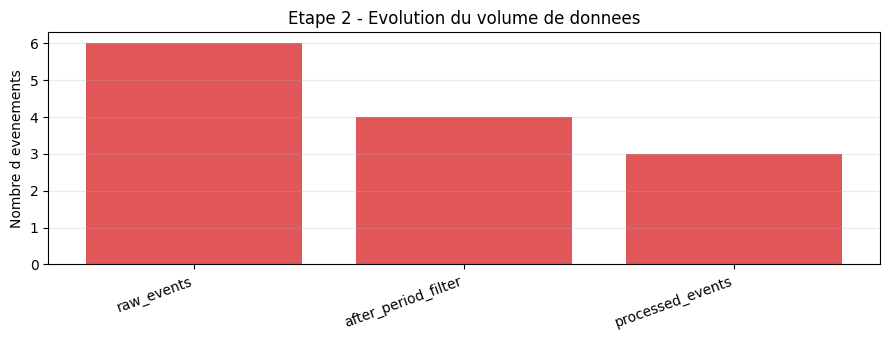

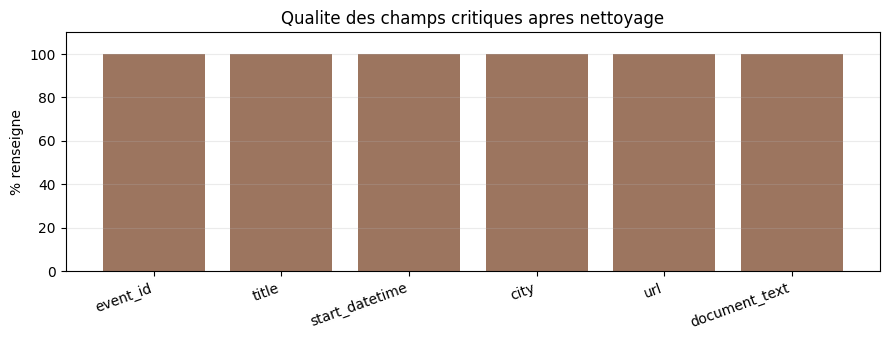

Etape 2 validee: donnees propres et schema stable.


In [5]:
from src.preprocess.cleaning import clean_events
from src.preprocess.schema import EVENT_RECORD_FIELDS


demo_raw_events = [
    {
        'uid': 'evt-jazz',
        'title': {'fr': 'Concert jazz a Montpellier'},
        'description': {'fr': 'Trio jazz local et jam session.'},
        'firstTiming': {'begin': '2025-07-12T20:00:00Z', 'end': '2025-07-12T22:00:00Z'},
        'location': {'name': {'fr': 'Place de la Comedie'}, 'address': 'Centre-ville', 'city': 'Montpellier', 'latitude': 43.6119, 'longitude': 3.8772},
        'canonicalUrl': 'https://example.org/evt-jazz',
        'tags': ['musique', 'jazz'],
    },
    {
        'uid': 'evt-jazz',
        'title': {'fr': 'Concert jazz a Montpellier'},
        'description': {'fr': 'Version dupliquee'},
        'firstTiming': {'begin': '2025-07-12T20:00:00Z', 'end': '2025-07-12T22:00:00Z'},
        'location': {'name': {'fr': 'Place de la Comedie'}, 'city': 'Montpellier'},
        'canonicalUrl': 'https://example.org/evt-jazz-dup',
    },
    {
        'uid': 'evt-theatre',
        'title': {'fr': 'Piece de theatre a Sete'},
        'description': {'fr': 'Theatre contemporain.'},
        'firstTiming': {'begin': '2025-07-20T19:00:00Z', 'end': '2025-07-20T21:00:00Z'},
        'location': {'name': {'fr': 'Scene nationale'}, 'city': 'Sete'},
        'canonicalUrl': 'https://example.org/evt-theatre',
        'tags': ['theatre'],
    },
    {
        'uid': 'evt-photo',
        'title': {'fr': 'Exposition photo a Beziers'},
        'description': {'fr': 'Patrimoine mediterraneen.'},
        'firstTiming': {'begin': '2025-08-04T10:00:00Z', 'end': '2025-08-04T18:00:00Z'},
        'location': {'name': {'fr': 'Galerie municipale'}, 'city': 'Beziers'},
        'canonicalUrl': 'https://example.org/evt-photo',
        'tags': ['photo', 'expo'],
    },
    {
        'uid': 'evt-old',
        'title': {'fr': 'Evenement trop ancien'},
        'firstTiming': {'begin': '2023-01-01T10:00:00Z'},
        'location': {'city': 'Montpellier'},
    },
    {
        'uid': 'evt-missing-title',
        'title': {'fr': ''},
        'firstTiming': {'begin': '2025-06-02T10:00:00Z'},
        'location': {'city': 'Montpellier'},
    },
]

processed, stats = clean_events(
    raw_events=demo_raw_events,
    start_date='2025-01-01',
    end_date='2026-01-31',
    language='fr',
    source='openagenda',
)

stats_df = pd.DataFrame([{'metric': k, 'value': v} for k, v in stats.items()])
display(stats_df)

clean_df = pd.DataFrame(processed)
display(clean_df[['event_id', 'title', 'start_datetime', 'city', 'url', 'document_text']].head())

pipeline_labels = ['raw_events', 'after_period_filter', 'processed_events']
pipeline_values = [stats['raw_events'], stats['after_period_filter'], stats['processed_events']]
draw_bar(pipeline_labels, pipeline_values, 'Etape 2 - Evolution du volume de donnees', ylabel='Nombre d evenements', color='#e15759')

required_fields = ['event_id', 'title', 'start_datetime', 'city', 'url', 'document_text']
completeness = []
for field in required_fields:
    non_empty = clean_df[field].fillna('').astype(str).str.strip().ne('').mean() if not clean_df.empty else 0
    completeness.append(round(non_empty * 100, 1))

if MATPLOTLIB_OK:
    fig, ax = plt.subplots(figsize=(9, 3.5))
    ax.bar(required_fields, completeness, color='#9c755f')
    ax.set_ylim(0, 110)
    ax.set_ylabel('% renseigne')
    ax.set_title('Qualite des champs critiques apres nettoyage')
    ax.grid(axis='y', alpha=0.25)
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()

assert stats['processed_events'] >= 3
assert set(clean_df.columns) == set(EVENT_RECORD_FIELDS)
print('Etape 2 validee: donnees propres et schema stable.')


## 5) Etape 2 - Simulation des sorties fichiers

Lecture metier:

On verifie qu'un collegue peut relancer le pipeline et obtenir les artefacts attendus,
sans intervention manuelle.


,fichier,taille_octets
0,events_raw.jsonl,1714
1,events_processed.parquet,14911


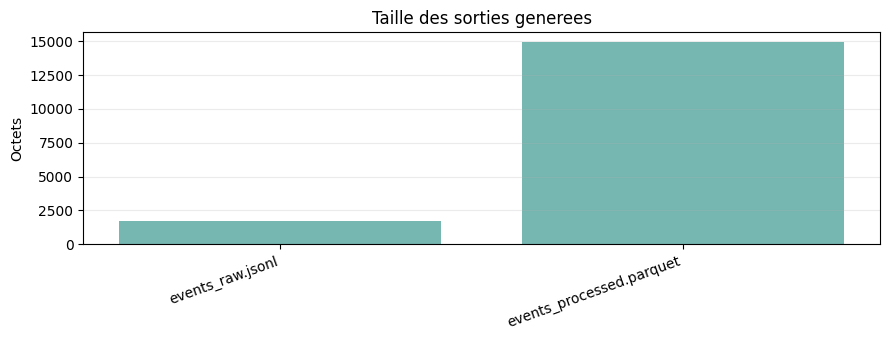

Sorties fichiers validees.


In [6]:
with tempfile.TemporaryDirectory() as tmp_dir:
    tmp = Path(tmp_dir)
    raw_path = tmp / 'events_raw.jsonl'
    processed_path = tmp / 'events_processed.parquet'

    with raw_path.open('w', encoding='utf-8') as f:
        for item in demo_raw_events:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

    pd.DataFrame(processed).to_parquet(processed_path, index=False)

    file_stats = pd.DataFrame([
        {'fichier': raw_path.name, 'taille_octets': raw_path.stat().st_size},
        {'fichier': processed_path.name, 'taille_octets': processed_path.stat().st_size},
    ])
    display(file_stats)
    draw_bar(list(file_stats['fichier']), list(file_stats['taille_octets']), 'Taille des sorties generees', ylabel='Octets', color='#76b7b2')

print('Sorties fichiers validees.')


## 6) Etape 3 - Indexation FAISS et recherche locale

Lecture metier:

Cette etape transforme les textes en vecteurs numeriques pour retrouver vite
des evenements proches d'une question utilisateur.

Ce que nous verifions:
- le chunking (decoupage en morceaux),
- la construction/recharge de l'index,
- une recherche locale top-k lisible.


Nombre de chunks: 13


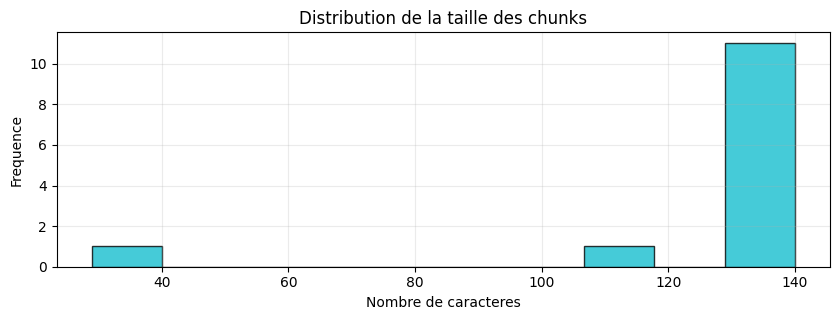

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.
`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


Index temporaire construit dans: /var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/stage34_validation_5g28jpno/faiss_index
Chunks indexes: 3


,rank,score,event_id,city,url
0,1,1.143906,evt-jazz,Montpellier,https://example.org/evt-jazz
1,2,1.735267,evt-theatre,Sete,https://example.org/evt-theatre
2,3,2.000000,evt-photo,Beziers,https://example.org/evt-photo


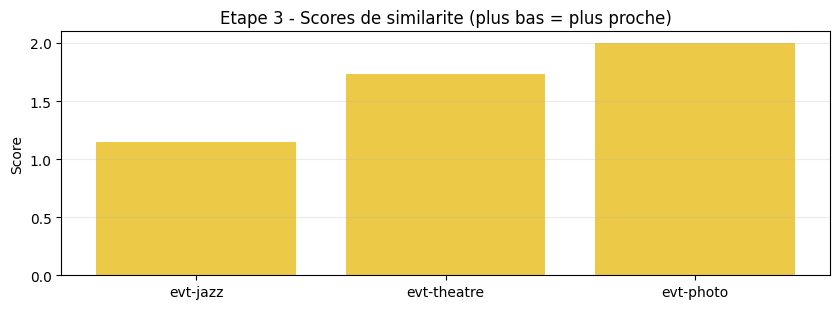

Etape 3 validee: retrieval local coherent.


In [7]:
from src.indexing.chunking import ChunkingConfig, split_text_into_chunks
from src.indexing.build_index import build_faiss_index, load_faiss_index
from src.indexing.search import search_similar_chunks


try:
    import faiss  # noqa: F401
except Exception as exc:
    raise RuntimeError('FAISS indisponible. Verifier les dependances.') from exc


class FakeEmbeddings:
    # Embeddings deterministes pour test offline.
    def __init__(self, dimension: int = 64) -> None:
        self.dimension = dimension

    def _embed(self, text: str):
        vector = [0.0] * self.dimension
        for idx, token in enumerate(text.lower().split()):
            digest = hashlib.sha256(token.encode('utf-8')).digest()
            bucket = digest[0] % self.dimension
            vector[(bucket + idx) % self.dimension] += (digest[1] / 255.0) + 0.01
        norm = sum(v * v for v in vector) ** 0.5 or 1.0
        return [v / norm for v in vector]

    def embed_documents(self, texts):
        return [self._embed(text) for text in texts]

    def embed_query(self, text):
        return self._embed(text)

    def __call__(self, text):
        return self.embed_query(text)


# 6.1 Chunking pedagogique
chunk_cfg = ChunkingConfig(chunk_size=140, chunk_overlap=20, min_chunk_size=30)
chunk_text = ('Concert jazz a Montpellier. ' * 60).strip()
chunks = split_text_into_chunks(chunk_text, chunk_cfg)
chunk_lengths = [len(c) for c in chunks]
print('Nombre de chunks:', len(chunks))

if MATPLOTLIB_OK:
    fig, ax = plt.subplots(figsize=(8.5, 3.3))
    ax.hist(chunk_lengths, bins=min(10, len(chunk_lengths)), color='#17becf', edgecolor='black', alpha=0.8)
    ax.set_title('Distribution de la taille des chunks')
    ax.set_xlabel('Nombre de caracteres')
    ax.set_ylabel('Frequence')
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


# 6.2 Build + recherche locale (temporaire)
stage34_tmp_dir = Path(tempfile.mkdtemp(prefix='stage34_validation_'))
input_path = stage34_tmp_dir / 'events_processed.parquet'
index_dir = stage34_tmp_dir / 'faiss_index'

mini_df = pd.DataFrame([
    {
        'event_id': 'evt-jazz',
        'title': 'Concert jazz a Montpellier',
        'document_text': 'Concert jazz en plein air a Montpellier avec trio local et jam session.',
        'start_datetime': '2025-07-12T20:00:00Z',
        'end_datetime': '2025-07-12T22:00:00Z',
        'city': 'Montpellier',
        'location_name': 'Place de la Comedie',
        'url': 'https://example.org/evt-jazz',
        'source': 'openagenda',
        'retrieval_metadata': {'tags': ['jazz', 'musique'], 'department': '34'},
    },
    {
        'event_id': 'evt-theatre',
        'title': 'Piece de theatre',
        'document_text': 'Representation de theatre contemporain a Sete.',
        'start_datetime': '2025-07-20T19:00:00Z',
        'end_datetime': '2025-07-20T21:00:00Z',
        'city': 'Sete',
        'location_name': 'Scene nationale',
        'url': 'https://example.org/evt-theatre',
        'source': 'openagenda',
        'retrieval_metadata': {'tags': ['theatre'], 'department': '34'},
    },
    {
        'event_id': 'evt-photo',
        'title': 'Expo photo',
        'document_text': 'Exposition photographique sur le patrimoine mediterraneen a Beziers.',
        'start_datetime': '2025-08-04T10:00:00Z',
        'end_datetime': '2025-08-04T18:00:00Z',
        'city': 'Beziers',
        'location_name': 'Galerie municipale',
        'url': 'https://example.org/evt-photo',
        'source': 'openagenda',
        'retrieval_metadata': {'tags': ['photo'], 'department': '34'},
    },
])
mini_df.to_parquet(input_path, index=False)

stage3_config = {
    'paths': {'input_dataset': str(input_path), 'output_dir': str(index_dir)},
    'chunking': {'chunk_size': 180, 'chunk_overlap': 30, 'min_chunk_size': 40, 'separators': ['\n\n', '\n', '. ', ' ', '']},
    'embeddings': {'provider': 'huggingface', 'huggingface_model': 'intfloat/multilingual-e5-small', 'mistral_model': 'mistral-embed'},
    'faiss': {'normalize_L2': True},
    'search': {'top_k': 5},
}

fake_embeddings = FakeEmbeddings()
build_result = build_faiss_index(
    input_path=input_path,
    output_dir=index_dir,
    config=stage3_config,
    embedding_model=fake_embeddings,
)

print('Index temporaire construit dans:', index_dir)
print('Chunks indexes:', build_result.chunks_count)

results = search_similar_chunks(
    query='Je cherche un concert jazz a Montpellier',
    index_dir=index_dir,
    k=3,
    config=stage3_config,
    embedding_model=fake_embeddings,
)
res_df = pd.DataFrame([
    {
        'rank': r['rank'],
        'score': r['score'],
        'event_id': r['metadata'].get('event_id', ''),
        'city': r['metadata'].get('city', ''),
        'url': r['metadata'].get('url', ''),
    }
    for r in results
])
display(res_df)

if MATPLOTLIB_OK and not res_df.empty:
    plot_df = res_df.copy()
    plot_df['score_plot'] = plot_df['score'].fillna(0)
    fig, ax = plt.subplots(figsize=(8.5, 3.2))
    ax.bar(plot_df['event_id'], plot_df['score_plot'], color='#edc948')
    ax.set_title('Etape 3 - Scores de similarite (plus bas = plus proche)')
    ax.set_ylabel('Score')
    ax.grid(axis='y', alpha=0.25)
    plt.tight_layout()
    plt.show()

assert len(results) >= 1
assert results[0]['metadata']['event_id'] == 'evt-jazz'
print('Etape 3 validee: retrieval local coherent.')


## 7) Etape 4 - Moteur RAG (retrieval + generation)

Lecture metier:

Ici on valide le coeur du produit:
- une question utilisateur,
- des evenements recuperes dans l'index,
- une reponse generee,
- des **sources explicites** (event_id, date, lieu, URL),
- des metadonnees de pilotage (latences, filtres, warnings).

Pour rester 100% relancable et sans cout, la generation est faite avec un **FakeLLM** deterministe.


In [8]:
from src.rag.llm import FakeLLMClient
from src.rag.retriever import RAGRetriever
from src.rag.service import RAGService
from src.rag.types import RAGConfig

vectorstore = load_faiss_index(
    index_dir=index_dir,
    config=stage3_config,
    embedding_model=fake_embeddings,
)

rag_config = RAGConfig(
    index_path=str(index_dir),
    retriever_top_k=4,
    max_sources=3,
    min_chunk_chars=10,
    context_max_chars=2600,
)

retriever = RAGRetriever(
    config=rag_config,
    vectorstore=vectorstore,
    embedding_model=fake_embeddings,
)

fake_llm = FakeLLMClient(
    fixed_answer=(
        'Synthese: voici des recommandations culturelles pertinentes dans l Herault.\n'
        '- Concert jazz a Montpellier | 2025-07-12 | Place de la Comedie | https://example.org/evt-jazz\n'
        '- Piece de theatre a Sete | 2025-07-20 | Scene nationale | https://example.org/evt-theatre\n'
        'Pourquoi ces choix ? Les suggestions correspondent au theme musical/culturel et a la zone demandee.'
    )
)

service = RAGService(config=rag_config, retriever=retriever, llm_client=fake_llm)
question = 'Quels evenements culturels recommandes-tu dans l Herault, avec priorite a Montpellier ?'
rag_result = service.ask(question, debug=True).model_dump()

print('Question:', rag_result['question'])
print('\nReponse:\n', rag_result['answer'])

sources_df = pd.DataFrame(rag_result['sources'])
meta_df = pd.DataFrame([rag_result['meta']])

display(Markdown('### Sources retournees'))
display(sources_df)

display(Markdown('### Meta execution'))
display(meta_df[['retriever_top_k', 'retrieved_chunks', 'returned_events', 'prompt_version', 'model']])

assert len(rag_result['sources']) >= 1
assert rag_result['meta']['returned_events'] <= rag_config.max_sources
assert 'latency_ms' in rag_result['meta']
assert 'url' in rag_result['sources'][0]

# Verification anti-hallucination: aucun chunk -> fallback
class EmptyRetriever:
    def load(self):
        return None

    def retrieve(self, *, question: str, top_k: int | None = None):
        del question, top_k
        return [], {'filters_applied': [], 'warnings': []}


fallback_service = RAGService(config=rag_config, retriever=EmptyRetriever(), llm_client=fake_llm)
fallback_result = fallback_service.ask('Question hors donnees').model_dump()
print('\nMessage fallback:', fallback_result['answer'])
assert 'Je ne peux pas répondre avec certitude' in fallback_result['answer']

print('Etape 4 validee: pipeline RAG + fallback anti-hallucination operationnels.')


`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


Question: Quels evenements culturels recommandes-tu dans l Herault, avec priorite a Montpellier ?

Reponse:
 Synthese: voici des recommandations culturelles pertinentes dans l Herault.
- Concert jazz a Montpellier | 2025-07-12 | Place de la Comedie | https://example.org/evt-jazz
- Piece de theatre a Sete | 2025-07-20 | Scene nationale | https://example.org/evt-theatre
Pourquoi ces choix ? Les suggestions correspondent au theme musical/culturel et a la zone demandee.


### Sources retournees

,event_id,title,start_datetime,end_datetime,city,location_name,url,score,snippet
0,evt-theatre,Piece de theatre,2025-07-20T19:00:00Z,2025-07-20T21:00:00Z,Sete,Scene nationale,https://example.org/evt-theatre,1.660636,Representation de theatre contemporain a Sete.
1,evt-jazz,Concert jazz a Montpellier,2025-07-12T20:00:00Z,2025-07-12T22:00:00Z,Montpellier,Place de la Comedie,https://example.org/evt-jazz,1.793943,Concert jazz en plein air a Montpellier avec t...
2,evt-photo,Expo photo,2025-08-04T10:00:00Z,2025-08-04T18:00:00Z,Beziers,Galerie municipale,https://example.org/evt-photo,1.881112,Exposition photographique sur le patrimoine me...


### Meta execution

,retriever_top_k,retrieved_chunks,returned_events,prompt_version,model
0,4,3,3,v1,mistral-small-latest



Message fallback: Je ne peux pas répondre avec certitude à partir des données disponibles. Vous pouvez reformuler en precisant la ville, la periode et le type d'evenement recherche.
Etape 4 validee: pipeline RAG + fallback anti-hallucination operationnels.


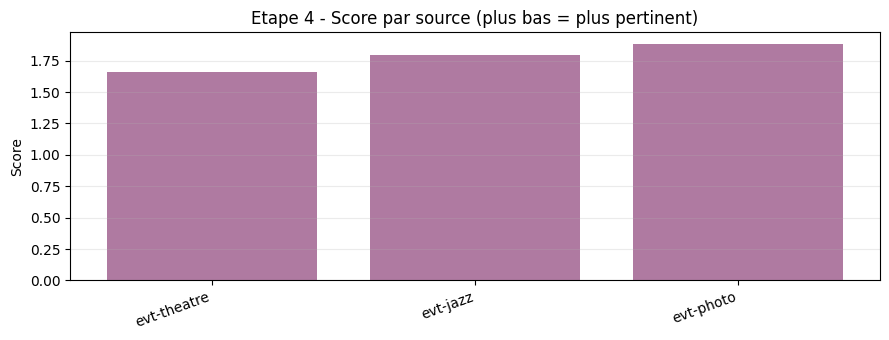

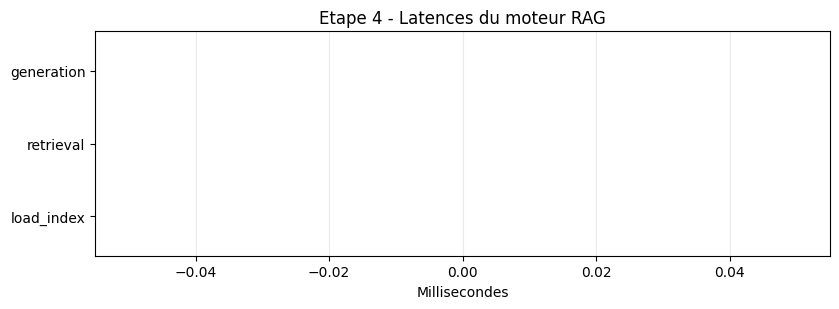

### KPI de pilotage Etape 4

,KPI,Valeur
0,Chunks recuperes,3
1,Evenements retournes,3
2,Contexte tronque,False
3,Warnings,0


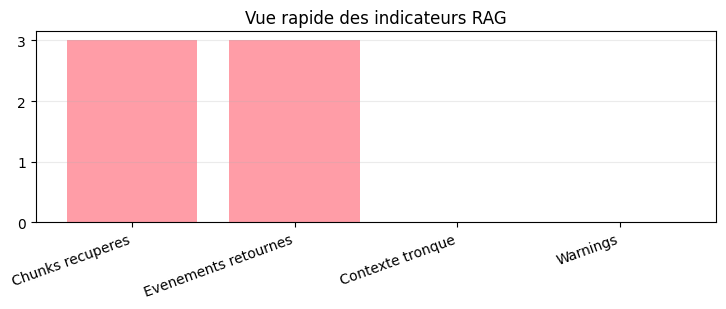

In [ ]:
import matplotlib.pyplot as plt

if not sources_df.empty:
    score_df = sources_df.copy()
    score_df['score_plot'] = score_df['score'].fillna(0)
    draw_bar(
        labels=list(score_df['event_id']),
        values=list(score_df['score_plot']),
        title='Etape 4 - Score par source (plus bas = plus pertinent)',
        ylabel='Score',
        color='#af7aa1',
    )

draw_latency(rag_result['meta']['latency_ms'], 'Etape 4 - Latences du moteur RAG')

kpi_rows = [
    {'KPI': 'Chunks recuperes', 'Valeur': rag_result['meta']['retrieved_chunks']},
    {'KPI': 'Evenements retournes', 'Valeur': rag_result['meta']['returned_events']},
    {'KPI': 'Contexte tronque', 'Valeur': rag_result['meta'].get('context_truncated', False)},
    {'KPI': 'Warnings', 'Valeur': len(rag_result['meta'].get('warnings', []))},
]
kpi_df = pd.DataFrame(kpi_rows)
display(Markdown('### KPI de pilotage Etape 4'))
display(kpi_df)

fig, ax = plt.subplots(figsize=(7.5, 3.2))
ax.bar(kpi_df['KPI'], [int(v) if isinstance(v, bool) else v for v in kpi_df['Valeur']], color='#ff9da7')
ax.set_title('Vue rapide des indicateurs RAG')
ax.grid(axis='y', alpha=0.25)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()


## 8) Validation finale (scripts projet)

Lecture metier:

Cette section execute les controles officiels du depot:
- `scripts/check_env.py` pour l'environnement,
- `pytest -q` pour l'ensemble des tests unitaires (dont Etape 4).


In [10]:
commands = [
    ['python3', 'scripts/check_env.py'],
    ['pytest', '-q'],
]

for cmd in commands:
    print('\n$ ' + ' '.join(cmd))
    completed = subprocess.run(cmd, text=True, capture_output=True)
    print(completed.stdout)
    if completed.returncode != 0:
        print(completed.stderr)
        raise RuntimeError(f"Commande en echec: {' '.join(cmd)}")

print('Validation globale Etapes 1 a 4: OK')



$ python3 scripts/check_env.py
=== Environment versions ===
python: 3.11.3
langchain: 0.0.353
faiss-cpu: 1.13.2
mistralai: 0.4.2
pandas: 2.2.2
requests: 2.32.3

=== Import checks ===
[OK] import faiss
[OK] from langchain.vectorstores import FAISS
[OK] from langchain.embeddings import HuggingFaceEmbeddings
[OK] from mistral import MistralClient

[SUCCESS] Environment smoke test passed.


$ pytest -q
...................                                                      [100%]
19 passed in 0.84s

Validation globale Etapes 1 a 4: OK
